In [4]:
# from extract_face import img
from config import get_config
from glob import glob
from utils import get_pred, get_pairs_intra_label, get_pairs_inter_label, findDistance_cos, findDistance, calc_diff_and_similar
from Learner import face_learner
# print(findDistance(np.array([2, 2]), np.array([1, 1])))

conf = get_config(False)
list_label_folder = glob(f"{conf.infer_dataset}/*")
list_label_folder = [folder for folder in list_label_folder if len(glob(f"{folder}/*")) != 0]

all_intra_pairs, all_inter_pairs = [], []

for path in list_label_folder[:10]:
    intra_pairs = get_pairs_intra_label(path)
    all_intra_pairs += intra_pairs
#     print(get_pairs_inter_label(path, list_label_folder, intra_pairs))
    all_inter_pairs += get_pairs_inter_label(path, list_label_folder, intra_pairs)

learner = face_learner(conf, True)
# learner.threshold = 1.54
if conf.device.type == 'cpu':
    learner.load_state(conf, 'cpu_final.pth', True, True)
else:
    learner.load_state(conf, 'final.pth', True, True)
learner.model.eval()
print('learner loaded')


diff1, similar1 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance, tta=False)
diff2, similar2 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance_cos, tta=False)


  0%|          | 0/11 [00:00<?, ?it/s]

ir_se_50 model generated
learner loaded


100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


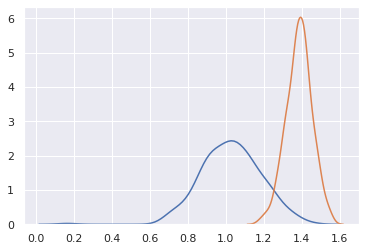

In [5]:
%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)
sns.distplot(similar1, hist=False)
sns.distplot(diff1, hist=False)

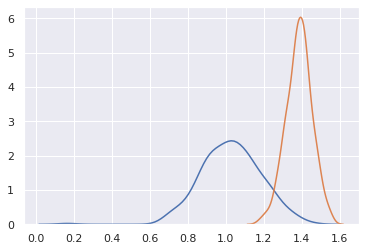

In [6]:
%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)
sns.distplot(similar1, hist=False)
sns.distplot(diff1, hist=False)

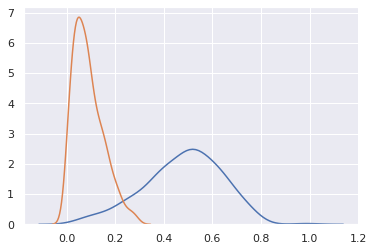

In [3]:
sns.set(color_codes=True)
sns.distplot(similar2, hist=False)
sns.distplot(diff2, hist=False)

In [7]:
range1 = [1, 1.2, 1.4]
range2 = [0.4, 0.7, 1]


step = 0.1
import numpy as np
y_true = np.concatenate((np.zeros(len(diff1)) , np.ones(len(similar1))), axis=0) 


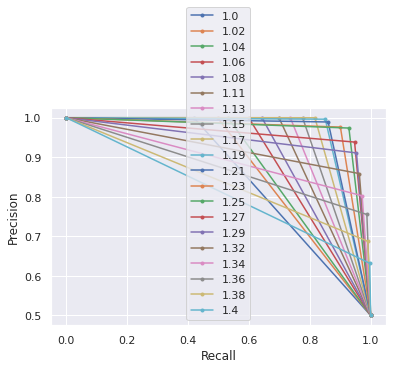

In [10]:
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_recall_curve
from matplotlib import pyplot

for threshold in np.linspace(1,1.4,20): 
    y_pred = get_pred(diff1, similar1, threshold)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pyplot.plot(recall, precision, marker='.', label=round(threshold, 2))

# threshold = 1.17
# y_pred = get_pred(diff1, similar1, threshold)
# precision, recall, _ = precision_recall_curve(y_true, y_pred)
# pyplot.plot(recall, precision, marker='.', label=round(threshold, 2))
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()

In [6]:
y_pred = get_pred(diff1, similar1, 1.16)
TP = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue == ypred == True])
TN = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue == ypred == False])
FP = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue != ypred and ypred == False])
FN = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue != ypred and ypred == True])
precision = TP/(TP+FN)
recall = TP/(TP+FP)
print(TP, TN, FP, FN, len(y_pred), precision, recall)

265 304 57 18 644 0.9363957597173145 0.8229813664596274


Best Threshold=1.000000, G-Mean=0.881
Best tpr=0.822981, fpr=0.055901


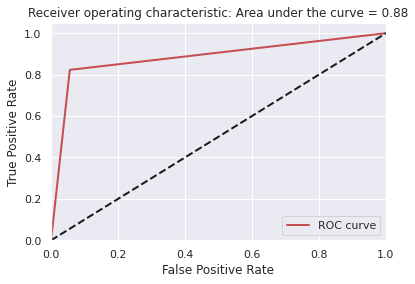

In [7]:
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix)
def plot_roc(true_label, prediction):
    fpr, tpr, threshs = roc_curve(true_label, prediction)
    auc_res = auc(fpr, tpr)

    # compute optimal threshold
    optimal_threshold_roc(tpr, fpr, threshs)

    # plot
    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.title('Receiver operating characteristic: Area under the curve '
              '= {0:0.2f}'.format(auc_res))
    plt.legend(loc='lower right')
    plt.show()

def optimal_threshold_roc(tpr, fpr, threshs):
    g_means = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(g_means)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshs[ix], g_means[ix]))
    print('Best tpr=%f, fpr=%f' % (tpr[ix], fpr[ix]))

    return threshs[ix]
import matplotlib.pyplot as plt
plot_roc(y_true, y_pred)

Best Threshold=0.023940, G-Mean=0.771
Best tpr=0.740000, fpr=0.195960


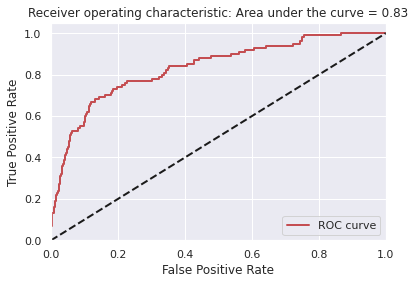

In [8]:
mean1 = [0, -0.25] # Negative
cov1 = [[0.1, 0.001],[0.001, 0.1]]
v1 = np.random.multivariate_normal(mean1, cov1, 9900)

mean2 = [0, 0.25] # Positive
cov2 = [[0.1, 0.001],[0.001, 0.1]]
v2 = np.random.multivariate_normal(mean2, cov2, 100)

true_label = np.concatenate((np.zeros(len(v1)), np.ones(len(v2))), axis=None)
predictions = np.concatenate((v1[:, 1], v2[:, 1]), axis=None)


plot_roc(true_label, predictions)